In [1]:
import configparser
import pyodbc
import os
import pandas as pd
import numpy as np
#from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
#from sklearn.linear_model import LinearRegression

In [2]:
# Check if the config.ini file exists in the current directory
if not os.path.exists('config.ini'):
    raise FileNotFoundError("The config.ini file is not found in the current directory")

# Create a ConfigParser object
config = configparser.ConfigParser()

# Read the configuration file
config.read('config.ini')

# Verify that the 'database' section exists
# if 'database' not in config:
#    raise KeyError("The 'database' section is not found in the config.ini file")

# Get the database credentials
db_server = config['database']['server']
db_user = config['database']['user']
db_password = config['database']['password']
db_database = config['database']['database']

# Create the database connection
conn_string = (
    'DRIVER={ODBC Driver 17 for SQL Server};'
    f'SERVER={db_server};'
    f'DATABASE={db_database};'
    f'UID={db_user};'
    f'PWD={db_password}'
)

In [3]:
# Conection manager
try:
    conn = pyodbc.connect(conn_string)
    print('Successful connection')
except pyodbc.Error as e:
    print('Error connecting to the database:', e)


Successful connection


In [4]:
# Create a cursor
cursor = conn.cursor()

# Define the SQL query
query = """SELECT [departure_city]
      ,[arrival_city]
      ,[scrape_date]
      ,[departure_date]
      ,[departure_date_distance]
      ,[departure_time]
      ,[arrival_time]
      ,[airline]
      ,[stops]
      ,[price]
  FROM [DWH].[dbo].[german_air_fares] WITH(NOLOCK)"""

# Execute the query
cursor.execute(query)

# Get the results
resultados = cursor.fetchall()

# Execute the query with the value
df = pd.read_sql(query, conn)

# Close conection
cursor.close()
conn.close()


C:\Users\alexm\AppData\Local\Temp\ipykernel_29804\3698108483.py:24: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [5]:
df

,departure_city,arrival_city,scrape_date,departure_date,departure_date_distance,departure_time,arrival_time,airline,stops,price
0,CGN Köln/Bonn,TXL Berlin-Tegel,2019-10-24,2019-11-07,14,08:15:00,09:25:00,Eurowings,0,152.0
1,CGN Köln/Bonn,TXL Berlin-Tegel,2019-10-24,2019-11-07,14,14:35:00,15:45:00,Eurowings,0,152.0
2,CGN Köln/Bonn,TXL Berlin-Tegel,2019-10-24,2019-11-07,14,07:10:00,08:25:00,Eurowings,0,152.0
3,CGN Köln/Bonn,TXL Berlin-Tegel,2019-10-24,2019-11-07,14,18:10:00,19:25:00,easyJet,0,168.0
4,CGN Köln/Bonn,TXL Berlin-Tegel,2019-10-24,2019-11-07,14,19:20:00,20:35:00,easyJet,0,168.0
...,...,...,...,...,...,...,...,...,...,...
61780,CGN Köln/Bonn,TXL Berlin-Tegel,2019-10-24,2019-11-07,14,12:30:00,13:40:00,Eurowings,0,102.0
61781,CGN Köln/Bonn,TXL Berlin-Tegel,2019-10-24,2019-11-07,14,10:50:00,12:05:00,Eurowings,0,102.0
61782,CGN Köln/Bonn,TXL Berlin-Tegel,2019-10-24,2019-11-07,14,12:00:00,13:15:00,Eurowings,0,102.0
61783,CGN Köln/Bonn,TXL Berlin-Tegel,2019-10-24,2019-11-07,14,14:35:00,15:50:00,Eurowings,0,102.0


In [6]:
# Average flight price by departure and arrival city
precio_promedio_ruta = df.groupby(['departure_city', 'arrival_city'])['price'].mean().reset_index()
print(precio_promedio_ruta)

           departure_city           arrival_city       price
0   BRE Bremen             FRA Frankfurt/Main     198.222462
1   BRE Bremen             MUC München            236.919598
2   BRE Bremen             STR Stuttgart          245.885135
3   CGN Köln/Bonn          DRS Dresden            272.570747
4   CGN Köln/Bonn          HAM Hamburg            171.319955
..                    ...                    ...         ...
85  TXL Berlin-Tegel       FRA Frankfurt/Main      79.718784
86  TXL Berlin-Tegel       MUC München             80.110251
87  TXL Berlin-Tegel       NUE Nürnberg           162.721792
88  TXL Berlin-Tegel       SCN Saarbrücken        868.844011
89  TXL Berlin-Tegel       STR Stuttgart          199.778462

[90 rows x 3 columns]


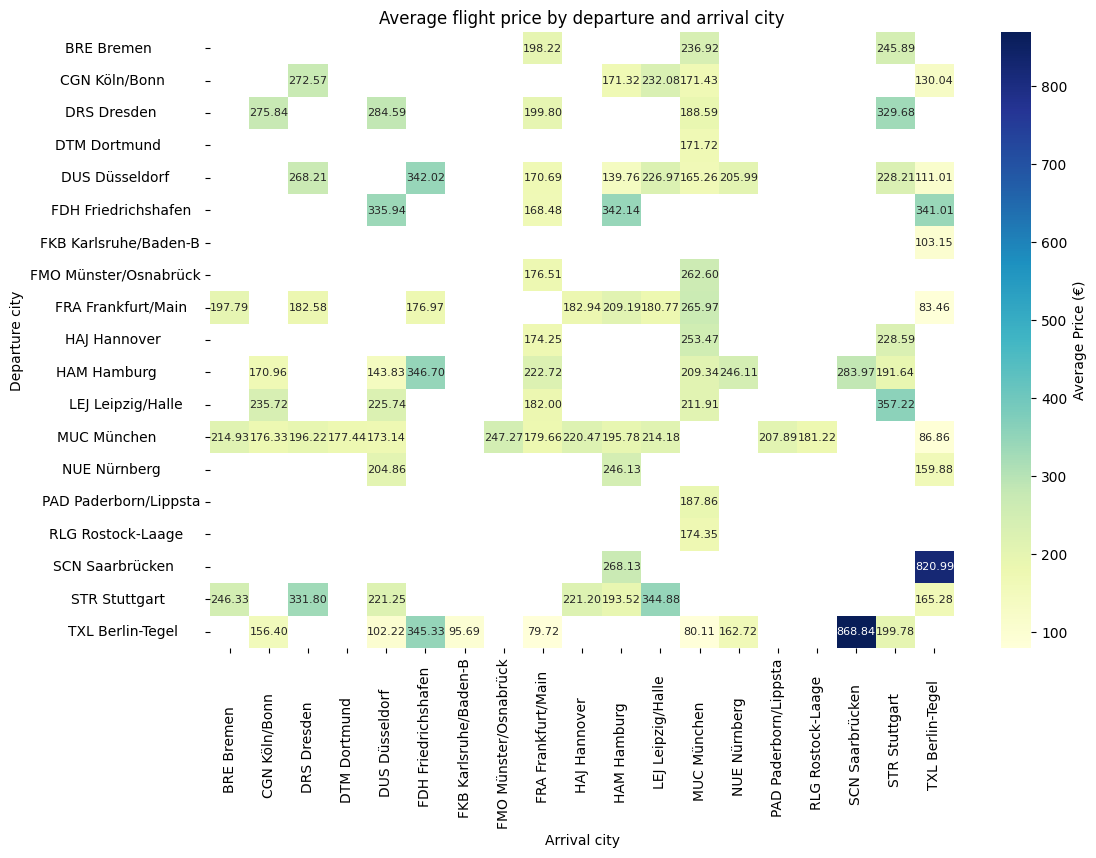

In [7]:
# Configuration to display inline plots
%matplotlib inline

# Average flight price by departure and arrival city
average_price_route = df.groupby(['departure_city', 'arrival_city'])['price'].mean().reset_index()

# Pivot table
pivot_table = average_price_route.pivot_table(index="departure_city", columns="arrival_city", values="price")

# Size of the plot
plt.figure(figsize=(12, 8))

# Smaller text
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Average Price (€)'}, annot_kws={"size": 8})

plt.title('Average flight price by departure and arrival city')
plt.xlabel('Arrival city')
plt.ylabel('Departure city')

plt.show()


In [8]:
# Convert departure_time to datetime
df['departure_time'] = pd.to_datetime(df['departure_time'], format='%H:%M:%S')

# Extract the departure hour
df['departure_hour'] = df['departure_time'].dt.hour

# Price distribution by departure hour
price_by_departure_hour = df.groupby('departure_hour')['price'].describe()
print(price_by_departure_hour)


                 count        mean         std    min     25%    50%     75%  \
departure_hour                                                                 
1                  4.0  765.750000    3.500000  764.0  764.00  764.0  765.75   
5                120.0  314.600000   90.963230  107.0  338.00  359.0  359.00   
6               7455.0  218.861838  122.323546   27.0  113.00  203.0  348.00   
7               3765.0  228.120584  194.428808   26.0  102.00  169.0  336.00   
8               5890.0  201.617487  121.058779   26.0  101.00  167.0  336.00   
9               4303.0  196.334650  114.354522   27.0  116.00  162.0  262.00   
10              5362.0  216.787579  138.412014   27.0  102.00  186.5  333.00   
11              2564.0  217.876365  166.456409   32.0  113.00  165.0  348.00   
12              2798.0  162.158327  132.608500   27.0   72.00  126.0  214.00   
13              3058.0  195.478744  162.501915   27.0  100.00  143.0  262.00   
14              4205.0  232.195244  145.

In [9]:
# Average flight price by booking distance
average_price_booking_distance = df.groupby('departure_date_distance')['price'].mean().reset_index()
print(average_price_booking_distance)

   departure_date_distance       price
0                        7  253.172774
1                       14  216.037166
2                       30  191.487908
3                       42  185.259768
4                       90  166.716038
5                      180  211.573179


C:\Users\alexm\AppData\Local\Temp\ipykernel_29804\2019326794.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='price', y='airline', data=average_price_airline, palette='viridis')


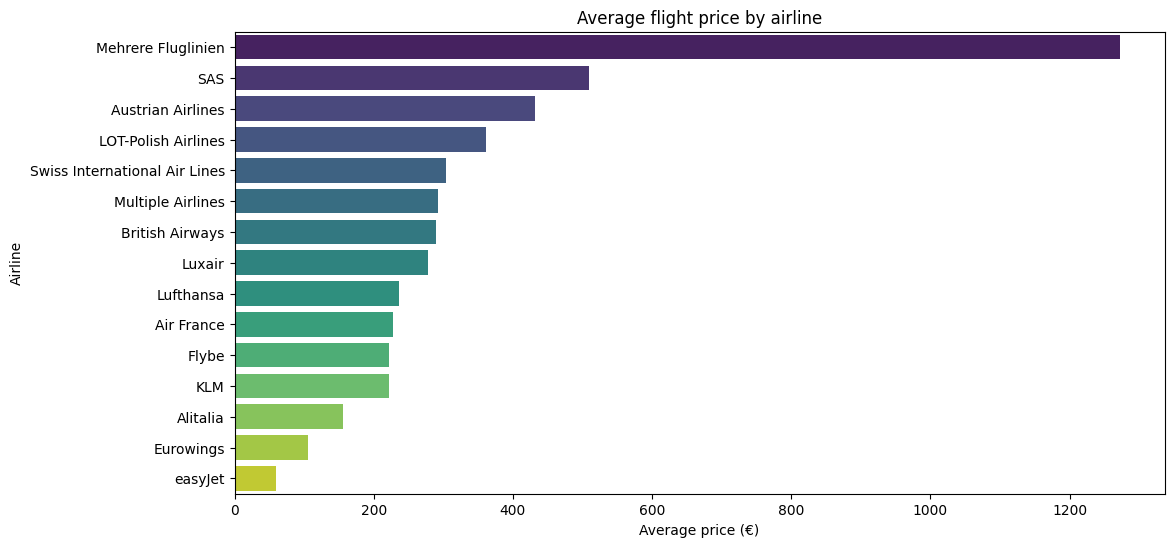

In [10]:
# Calculate the average flight price by airline
average_price_airline = df.groupby('airline')['price'].mean().reset_index()

# Sort the DataFrame by average price
average_price_airline = average_price_airline.sort_values(by='price', ascending=False)

# Set the size of the plot
plt.figure(figsize=(12, 6))

# Bar plot 
sns.barplot(x='price', y='airline', data=average_price_airline, palette='viridis')

plt.xlabel('Average price (€)')
plt.ylabel('Airline')
plt.title('Average flight price by airline')

plt.show()



In [11]:
# Calculate the average flight price by route and airline
average_price_route_airline = df.groupby(['departure_city', 'arrival_city', 'airline'])['price'].mean().reset_index()
average_price_route_airline

,departure_city,arrival_city,airline,price
0,BRE Bremen,FRA Frankfurt/Main,Lufthansa,198.222462
1,BRE Bremen,MUC München,Lufthansa,236.919598
2,BRE Bremen,STR Stuttgart,Air France,263.428571
3,BRE Bremen,STR Stuttgart,Eurowings,133.252033
4,BRE Bremen,STR Stuttgart,KLM,247.346154
...,...,...,...,...
217,TXL Berlin-Tegel,SCN Saarbrücken,Lufthansa,1047.509091
218,TXL Berlin-Tegel,SCN Saarbrücken,Luxair,283.928571
219,TXL Berlin-Tegel,STR Stuttgart,Eurowings,103.975610
220,TXL Berlin-Tegel,STR Stuttgart,Lufthansa,274.517740


C:\Users\alexm\AppData\Local\Temp\ipykernel_29804\1539625569.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')


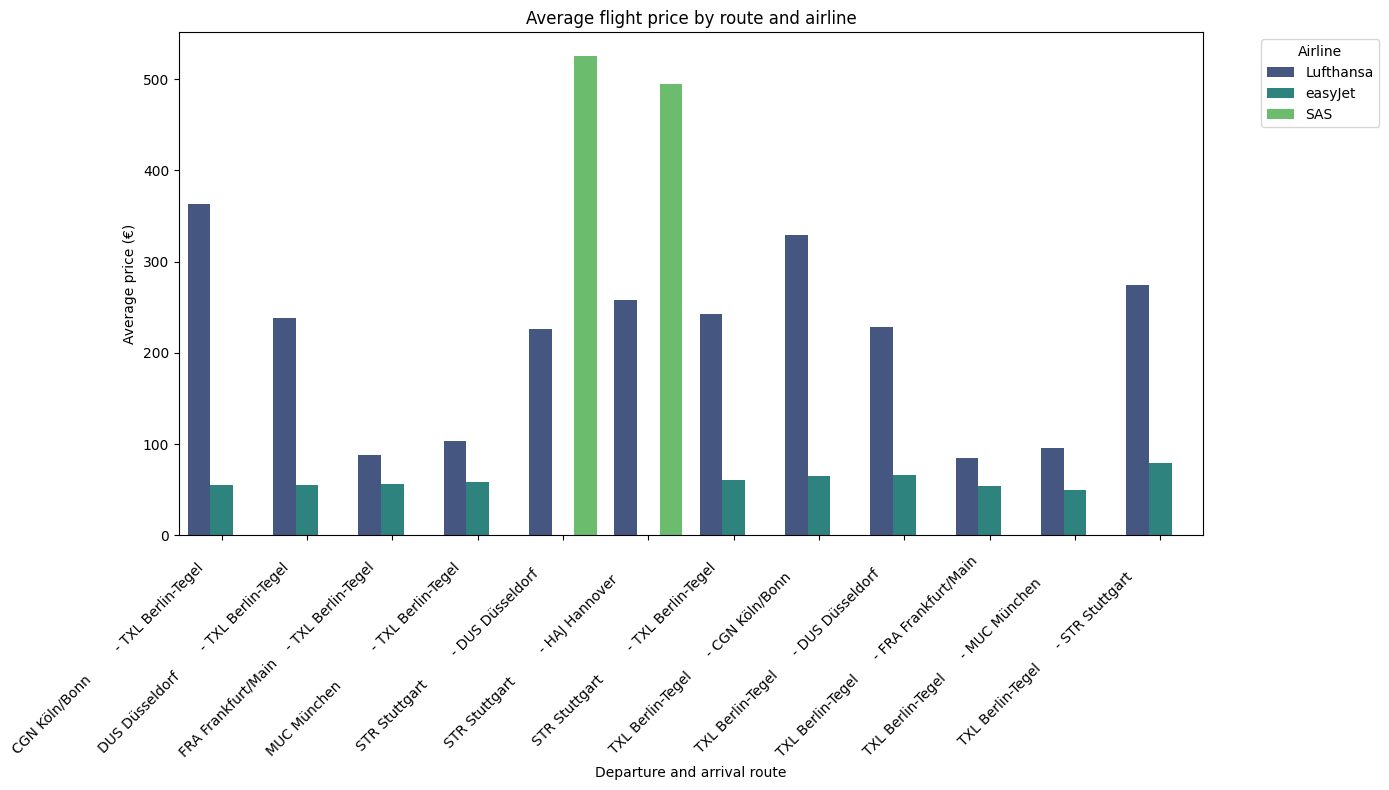

In [12]:
# Include only especific airlines
filtered_df = df[df['airline'].isin(['SAS', 'Lufthansa', 'easyJet'])]

# Average flight price by route and airline
average_price_route_airline = filtered_df.groupby(['departure_city', 'arrival_city', 'airline'])['price'].mean().reset_index()

# Create a combined route column for easier visualization
average_price_route_airline['route'] = average_price_route_airline['departure_city'] + ' - ' + average_price_route_airline['arrival_city']

# Flights operated by at least two airlines
route_counts = average_price_route_airline.groupby('route')['airline'].nunique()
routes_with_at_least_two_airlines = route_counts[route_counts >= 2].index

# filter to show the first 15 routes
first_5_routes = routes_with_at_least_two_airlines[:15]

# Filter the DataFrame
average_price_route_airline_5 = average_price_route_airline[average_price_route_airline['route'].isin(first_5_routes)]

# Size of the plot
plt.figure(figsize=(14, 8))

# Create the grouped bar plot
ax = sns.barplot(x='route', y='price', hue='airline', data=average_price_route_airline_5, palette='viridis')

# Rotate the x-axis labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

# Labels and title
plt.xlabel('Departure and arrival route')
plt.ylabel('Average price (€)')
plt.title('Average flight price by route and airline')

# Legend in the plot
plt.legend(title='Airline', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to avoid overlap
plt.tight_layout()

plt.show()
